# Jupyter notebook de avaliação dos dados da produção da Brazilian FISH

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xlsxwriter
from tabulate import tabulate
import seaborn as sns

#from google.colab import drive
#from electre_tree import tree_e_tri_b , util_e_tri_b
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
#from yellowbrick.cluster import KElbowVisualizer
#from yellowbrick.cluster import SilhouetteVisualizer
# Required Libraries
import os


In [2]:
dataset = pd.DataFrame()
file = pd.ExcelFile('data\C_DADOS_BZF.xlsx')
sheets_list = ['Produção', 'Industria', 'Descrição']
for sheet in sheets_list:
    if 'Descrição' != sheet:
        temp_df = pd.read_excel(file, sheet_name=sheet)
        dataset = pd.concat([dataset, temp_df])
first_list = temp_df.columns.tolist()
temp_df = dataset.reset_index(drop=True)
#dataset.head()
len(dataset)

4504

In [3]:
xls = pd.ExcelFile('data\C_DADOS_BZF.xlsx')
prod= pd.read_excel(xls, 'Produção')
ind= pd.read_excel(xls, 'Industria')

In [4]:
## Eliminar espacos dos nomes das colunas
prod.columns = prod.columns.str.strip()

In [5]:
prod_num=prod.select_dtypes(include='number')


In [6]:
prod.select_dtypes(include='object').head()

,Unidade,Tanque,Fase,Tamanho,Lote,Data Encerramento,Curva,Status,Espécie,Tipo Tanque,Linha,Produto Origem,Fornecedor Origem
0,Unidade 3,TR111,Fase 3,P,L055-VAC,2022-03-29 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 10,Avulsa,Avulsa
1,Unidade 3,TR142,Fase 3,M,L055-VAC,2022-03-07 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 09,Avulsa,Avulsa
2,Unidade 3,TR254,Fase 3,G,L055-VAC,2022-02-17 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 03,Avulsa,Avulsa
3,Unidade 3,TR123,Fase 3,M,L057-VAC,2022-03-08 00:00:00,F3 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,NaN,Avulsa,Avulsa
4,Unidade 3,TR670,Fase 4,G,L048-VAC,2022-03-08 00:00:00,F4 VERÃO - Engorda 100%,Encerrado,Tilápia,Engorda,U.3 - LINHA 07,Avulsa,Avulsa


In [7]:
prod_cat=prod.select_dtypes(include='object')

In [8]:
prod_num = prod_num.drop(columns=[
'Peso Estimado Biometria',
'Biomassa Biometria',
'Peso Médio Últ. Biometria',
'Peso Médio Biometria',
'Biomassa Despesca',
'Peso Médio Despesca',
'Densidade',
'Peso Médio Atual',
'Custo Insumos',
'Custo Alevinos',
'Custo Indireto',
'Densidade Máxima', 
'Sequência',
'Outras Saídas',
'Biomassa Atual', 
'Saldo'
])

prod_num.head()

,ID Lote,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,...,Custo Entrada/Kg,Custo Entrada/Unidades,Custo Ração,Custos Totais (Peixe),Custos Totais (Biomassa),Custo/Kg,Custo/Peixe,Ração Nominal,Ração Real,% Nominal/Real
0,7201,85,46.0,8089,2254,204,72.184448,5839,423.317349,45.973186,...,8.534688,0.996213,15951.667908,24010.032110,19125.523013,7.737645,4.112011,5279.906040,4239.251772,80.290288
1,7202,63,84.0,8176,1549,235,81.054305,6627,431.821639,82.102740,...,8.103403,0.989867,14540.378988,22633.531848,19979.966837,6.981896,3.415351,4359.112894,3821.237976,87.660909
2,7203,45,188.0,8516,1307,98,84.652419,7209,418.401304,179.250705,...,7.900471,0.975564,9409.738452,17717.644222,21469.799126,7.118032,2.457712,3704.695446,2902.144641,78.336929
3,7206,63,80.0,8152,1590,157,80.495584,6562,413.567815,77.539500,...,7.862117,0.969881,14890.776107,22797.248557,19860.435832,7.318226,3.474131,4298.687760,3828.892759,89.071200
4,7207,63,590.0,8100,328,328,96.604938,7825,900.000000,583.146914,...,7.561200,6.589881,21862.674185,75240.713679,57577.926096,8.175779,9.615427,6845.448715,6354.039134,92.821368


In [9]:
prod_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970 entries, 0 to 1969
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID Lote                         1970 non-null   int64  
 1   nº Dias                         1970 non-null   int64  
 2   Peso Médio Inicial              1970 non-null   float64
 3   Quantidade Inicial              1970 non-null   int64  
 4   Mortalidade                     1970 non-null   int64  
 5   Mortalidade Coletada            1970 non-null   int64  
 6   Sobrevivência                   1970 non-null   float64
 7   Saldo Final                     1970 non-null   int64  
 8   Peso Médio Saída                1970 non-null   float64
 9   Peso Médio Entrada              1970 non-null   float64
 10  Biomassa Final                  1970 non-null   float64
 11  Biomassa Inicial                1970 non-null   float64
 12  Biomassa Ganha                  19

## Saldo Final, Peso Médio Saída e Biomassa Final possuem 286 linhas zeradas

In [10]:
prod_num_286 =prod_num[prod_num['Saldo Final'] != 0]
prod_num_286.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 0 to 1920
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID Lote                         1684 non-null   int64  
 1   nº Dias                         1684 non-null   int64  
 2   Peso Médio Inicial              1684 non-null   float64
 3   Quantidade Inicial              1684 non-null   int64  
 4   Mortalidade                     1684 non-null   int64  
 5   Mortalidade Coletada            1684 non-null   int64  
 6   Sobrevivência                   1684 non-null   float64
 7   Saldo Final                     1684 non-null   int64  
 8   Peso Médio Saída                1684 non-null   float64
 9   Peso Médio Entrada              1684 non-null   float64
 10  Biomassa Final                  1684 non-null   float64
 11  Biomassa Inicial                1684 non-null   float64
 12  Biomassa Ganha                  16

## Custo Total Entrada(Biomassa), Custo Total Entrada (Peixe), Custo Entrada/Kg e Custo Entrada/Unidades possuem 144 linhas zeradas


In [11]:
prod_num_144 =prod_num[prod_num['Custo Entrada/Kg'] != 0]
prod_num_144.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1943
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID Lote                         1826 non-null   int64  
 1   nº Dias                         1826 non-null   int64  
 2   Peso Médio Inicial              1826 non-null   float64
 3   Quantidade Inicial              1826 non-null   int64  
 4   Mortalidade                     1826 non-null   int64  
 5   Mortalidade Coletada            1826 non-null   int64  
 6   Sobrevivência                   1826 non-null   float64
 7   Saldo Final                     1826 non-null   int64  
 8   Peso Médio Saída                1826 non-null   float64
 9   Peso Médio Entrada              1826 non-null   float64
 10  Biomassa Final                  1826 non-null   float64
 11  Biomassa Inicial                1826 non-null   float64
 12  Biomassa Ganha                  18

In [12]:
prod_num_final =prod_num_286[prod_num_286['Custo Entrada/Kg'] != 0]
prod_num_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584 entries, 0 to 1920
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID Lote                         1584 non-null   int64  
 1   nº Dias                         1584 non-null   int64  
 2   Peso Médio Inicial              1584 non-null   float64
 3   Quantidade Inicial              1584 non-null   int64  
 4   Mortalidade                     1584 non-null   int64  
 5   Mortalidade Coletada            1584 non-null   int64  
 6   Sobrevivência                   1584 non-null   float64
 7   Saldo Final                     1584 non-null   int64  
 8   Peso Médio Saída                1584 non-null   float64
 9   Peso Médio Entrada              1584 non-null   float64
 10  Biomassa Final                  1584 non-null   float64
 11  Biomassa Inicial                1584 non-null   float64
 12  Biomassa Ganha                  15

In [13]:
#prod_num1=prod_num.iloc[:,:-20]

#prod_num2=prod_num.iloc[:,-20:]

In [14]:
dados = prod_num_final.copy()

tabela = tabulate(dados, headers="firstrow", tablefmt="sheet")

#dados.to_excel('prod_num.xlsx', index = False)

In [15]:
num_list = ['ID Lote',
'nº Dias',
'Peso Médio Inicial',
'Quantidade Inicial',
'Mortalidade',
'Mortalidade Coletada',
'Sobrevivência',
'Saldo Final',
'Peso Médio Saída',
'Peso Médio Entrada',
'Biomassa Final',
'Biomassa Inicial',
'Biomassa Ganha',
'GPD Fase',
'GPD Real',
]

<Axes: >

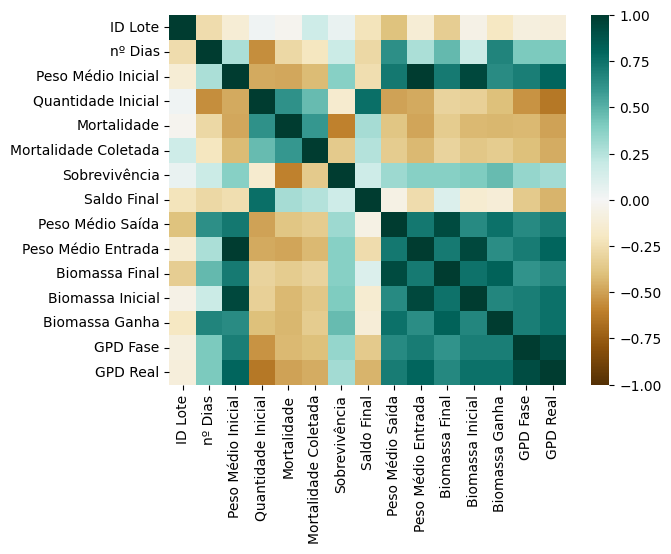

In [16]:
#ind_new = ind[num_list]
temp_df = prod_num.reset_index(drop=True)
temp_df = prod_num[num_list]
sns.heatmap(temp_df.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')

In [17]:
temp_df.head()

,ID Lote,nº Dias,Peso Médio Inicial,Quantidade Inicial,Mortalidade,Mortalidade Coletada,Sobrevivência,Saldo Final,Peso Médio Saída,Peso Médio Entrada,Biomassa Final,Biomassa Inicial,Biomassa Ganha,GPD Fase,GPD Real
0,7201,85,46.0,8089,2254,204,72.184448,5839,423.317349,45.973186,2471.750,371.8771,2099.8729,4.439028,4.439343
1,7202,63,84.0,8176,1549,235,81.054305,6627,431.821639,82.102740,2861.682,671.2720,2190.4100,5.520978,5.551094
2,7203,45,188.0,8516,1307,98,84.652419,7209,418.401304,179.250705,3016.255,1526.4990,1489.7560,5.120029,5.314458
3,7206,63,80.0,8152,1590,157,80.495584,6562,413.567815,77.539500,2713.832,632.1020,2081.7300,5.294727,5.333783
4,7207,63,590.0,8100,328,328,96.604938,7825,900.000000,583.146914,7042.500,4723.4900,2319.0100,4.920635,5.029414


In [18]:
num_list = ['Metragem Tanque',
'Custo Total Entrada (Biomassa)',
'Custo Total Entrada (Peixe)',
'Custo Entrada/Kg',
'Custo Entrada/Unidades',
'Custo Ração',
'Custos Totais (Peixe)',
'Custos Totais (Biomassa)',
'Custo/Kg',
'Custo/Peixe',
'Ração Nominal',
'Ração Real',
'% Nominal/Real',
'Conversão Alimentar',
'Conversão Acumulada'
]

<Axes: >

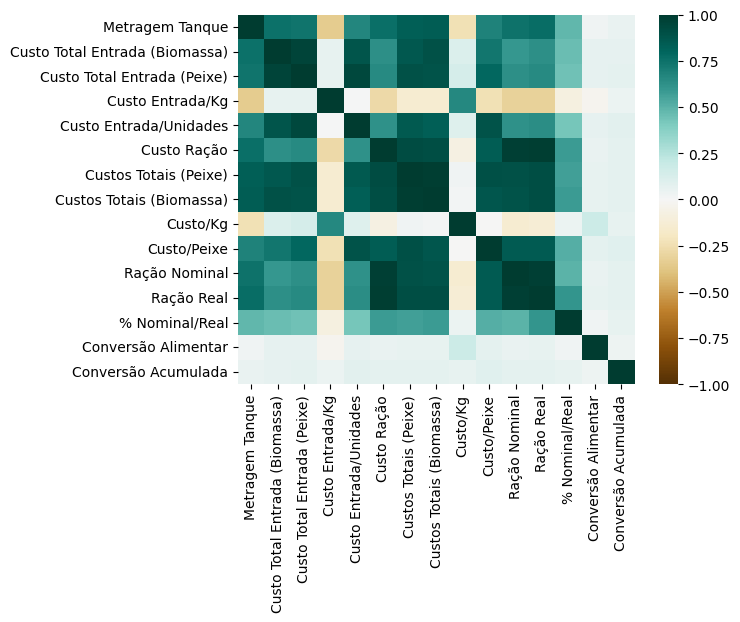

In [19]:
#ind_new = ind[num_list]
temp_df = prod_num.reset_index(drop=True)
temp_df = prod_num[num_list]
sns.heatmap(temp_df.corr(),
           vmin = -1, vmax = 1, cmap = 'BrBG')